In [7]:
import pandas as pd

df = pd.read_csv("../data/clean/nifty_features_5min.csv")
df.head()


,timestamp,open,high,low,close,volume,ema_5,ema_15,spot_return,futures_return,delta_neutral_ratio,gamma_exposure,futures_basis,avg_iv,iv_spread,pcr_oi,pcr_volume
0,2025-08-25,226.48,229.30,226.230,227.16,30983133,227.560000,227.685000,-0.002634,0.0,1.214784,5971.69656,-0.691389,0.2,0.0,0.573228,0.473839
1,2025-08-26,226.87,229.49,224.690,229.31,54575107,228.143333,227.888125,0.009465,0.0,1.214784,5971.69656,-0.691389,0.2,0.0,0.573228,0.473839
2,2025-08-27,228.61,230.90,228.260,230.49,31259513,228.925556,228.213359,0.005146,0.0,1.214784,5971.69656,-0.691389,0.2,0.0,0.573228,0.473839
3,2025-08-28,230.82,233.41,229.335,232.56,38074700,230.137037,228.756689,0.008981,0.0,1.214784,5971.69656,-0.691389,0.2,0.0,0.573228,0.473839
4,2025-08-29,232.51,233.38,231.370,232.14,39418437,230.804691,229.179603,-0.001806,0.0,1.214784,5971.69656,-0.691389,0.2,0.0,0.573228,0.473839


In [11]:
features = [
    "avg_iv",
    "iv_spread",
    "pcr_oi",          # make sure this column exists
    "futures_basis",
    "spot_return"
]

X = df[features].dropna()


In [13]:
list(df.columns)

['timestamp',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'ema_5',
 'ema_15',
 'spot_return',
 'futures_return',
 'delta_neutral_ratio',
 'gamma_exposure',
 'futures_basis',
 'avg_iv',
 'iv_spread',
 'pcr_oi',
 'pcr_volume']

In [15]:
# Train-test split (time-based)
split_idx = int(len(X) * 0.7)

X_train = X.iloc[:split_idx]
X_test  = X.iloc[split_idx:]

X_train.shape, X_test.shape


((69, 5), (30, 5))

In [19]:
!pip install hmmlearn



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
from hmmlearn.hmm import GaussianHMM

hmm = GaussianHMM(
    n_components=3,
    covariance_type="diag",   # 👈 FIX HERE
    n_iter=1000,
    random_state=42
)

hmm.fit(X_train)


GaussianHMM(n_components=3, n_iter=1000, random_state=42)

In [24]:
hidden_states = hmm.predict(X)


In [28]:
# Create df_regime by attaching hidden states
df_regime = df.loc[X.index].copy()
df_regime["regime"] = hidden_states


In [30]:
# Calculate mean spot return per hidden state
state_returns = (
    df_regime
    .groupby("regime")["spot_return"]
    .mean()
    .sort_values()
)

state_returns


regime
0    0.000739
1    0.002074
Name: spot_return, dtype: float64

In [32]:
# Sort regimes by mean return
sorted_states = state_returns.index.tolist()

# Map regimes
regime_map = {
    sorted_states[0]: -1,   # lowest return → Downtrend
    sorted_states[-1]: 1    # highest return → Uptrend
}

# If a middle regime exists, mark it sideways
if len(sorted_states) == 3:
    regime_map[sorted_states[1]] = 0

regime_map


{0: -1, 1: 1}

In [34]:
# Map hidden states to market regimes
df_regime["market_regime"] = df_regime["regime"].map(regime_map)

df_regime[["regime", "market_regime"]].head()


,regime,market_regime
0,1,1
1,0,-1
2,1,1
3,0,-1
4,1,1


In [36]:
df_regime["market_regime"].value_counts()


market_regime
 1    50
-1    49
Name: count, dtype: int64

## TASK 3.2: Regime Visualization

## Price chart with regime overlay (color-coded)

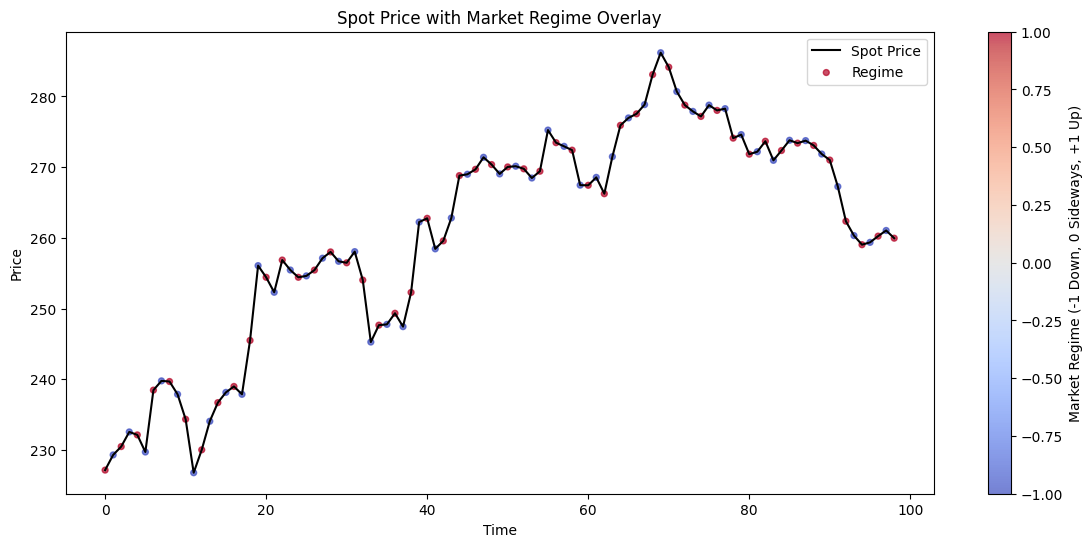

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Plot price
plt.plot(df_regime.index, df_regime["close"], color="black", label="Spot Price")

# Overlay regimes
plt.scatter(
    df_regime.index,
    df_regime["close"],
    c=df_regime["market_regime"],
    cmap="coolwarm",
    s=18,
    alpha=0.7,
    label="Regime"
)

plt.title("Spot Price with Market Regime Overlay")
plt.xlabel("Time")
plt.ylabel("Price")
plt.colorbar(label="Market Regime (-1 Down, 0 Sideways, +1 Up)")
plt.legend()
plt.show()


## Regime Transition Heatmap

In [73]:
stats = (
    df_regime
    .groupby("market_regime")[[
        "avg_iv",
        "iv_spread",
        "delta_neutral_ratio",
        "gamma_exposure"
    ]]
    .mean()
)

stats


,avg_iv,iv_spread,delta_neutral_ratio,gamma_exposure
market_regime,,,,
-1,0.2,0.0,1.214784,5971.69656
1,0.2,0.0,1.214784,5971.69656


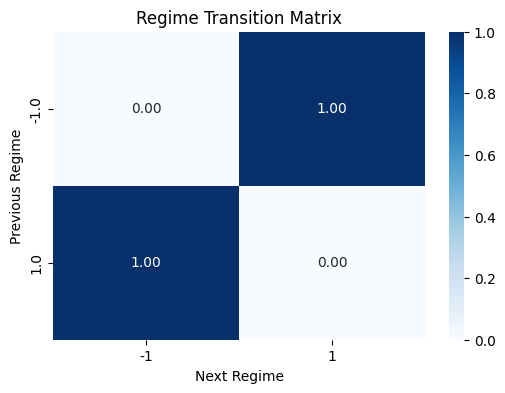

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

# Transition matrix (already correct)
transitions = pd.crosstab(
    df_regime["market_regime"].shift(1),
    df_regime["market_regime"],
    normalize="index"
)

plt.figure(figsize=(6, 4))
sns.heatmap(
    transitions,
    annot=True,
    cmap="Blues",
    fmt=".2f"
)
plt.title("Regime Transition Matrix")
plt.xlabel("Next Regime")
plt.ylabel("Previous Regime")
plt.show()


##  Regime statistics (IV, Greeks distribution per regime)

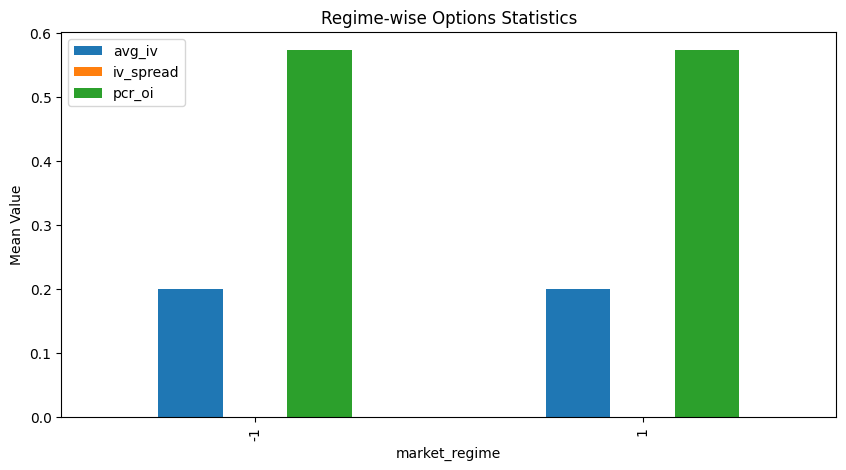

In [47]:
regime_stats.plot(kind="bar", figsize=(10,5))
plt.title("Regime-wise Options Statistics")
plt.ylabel("Mean Value")
plt.show()


In [53]:
# Calculate duration of each regime segment
regime_durations = (
    df_regime
    .groupby((df_regime["market_regime"] != df_regime["market_regime"].shift()).cumsum())
    .agg(
        regime=("market_regime", "first"),
        duration=("market_regime", "size")
    )
)

regime_durations.head()


,regime,duration
market_regime,,
1,1,1
2,-1,1
3,1,1
4,-1,1
5,1,1


In [61]:
df_regime = df_regime.sort_index()

In [63]:
df_regime["regime_change"] = (
    df_regime["market_regime"] != df_regime["market_regime"].shift(1)
)

In [65]:
df_regime["regime_group"] = df_regime["regime_change"].cumsum()

In [67]:
regime_durations = (
    df_regime
    .groupby(["regime_group", "market_regime"])
    .size()
    .reset_index(name="duration")
)

## Duration histogram

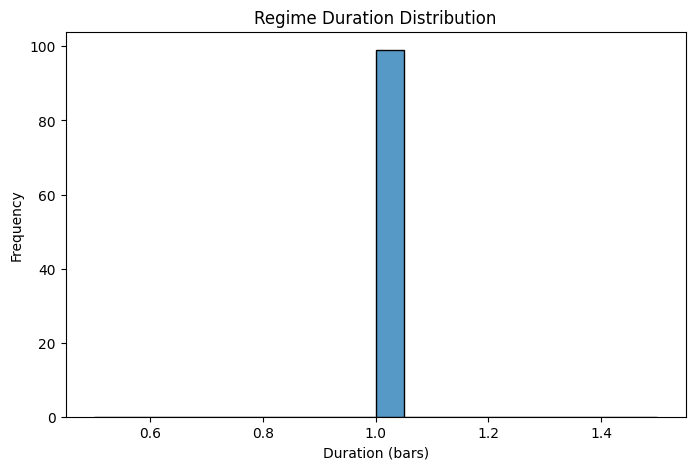

In [69]:
plt.figure(figsize=(8, 5))

sns.histplot(
    regime_durations["duration"],
    bins=20,
    kde=False
)

plt.title("Regime Duration Distribution")
plt.xlabel("Duration (bars)")
plt.ylabel("Frequency")
plt.show()


In [83]:
df_regime.to_csv("df_regime.csv", index=False)
